In [43]:
import pandas as pd
import numpy as np
import scanpy
import scipy
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime

In [2]:
# NOTES:
# requires 200 cells per cell type or else will return empty results for iterative PCA
# ISSUES:
# option to just select all genes and compute no variable genes!
# the scaling in seurat leads to completely different results (my method just standardizes normally) -- when you regress out variables, not sure what's happening so just compared to base R
# the identification of finding most variable genes in scanpy is different than seurat even thought the flavor is seurat, some of the genes may have dashes instead of periods
# strong consistency in eigenvalues learned but not eigenvectors or projections because there precision/algorithm differences (flipped eigenvalues towards the end) -- first 40 PCs are very consistent

In [3]:
# TESTS:
# tested identical normalization
# tested identical standardization
# tested identical regression of (residual) AGE, SEX, and BATCH
# tested identiacal regression (residual) of AGE, SEX, BATCH, and CELL TYPE
# tested PCA output for cond and stand
#option of vargenes == all so that you don't subset

# TO DO:
# only add cell type to regress out
# accept name for directory to output
# CONFUSING WHY MEAN VARIANCE IS NOT LINEAR IDK MAYBE BC OF DOWNSAMPLING
# MAKE BIC OPTIONAL
# vars to regress argument

# SCANPY REFERENCES
# UMAP: https://github.com/scverse/scanpy/blob/master/scanpy/tools/_umap.py
# PCA: https://github.com/scverse/scanpy/blob/master/scanpy/preprocessing/_pca.py
# My question: https://github.com/scverse/scanpy/issues/2780

In [49]:
# f'CondPCA_Run_{datetime.now().replace(":", "_")}'


'CondPCA_run_2024-01-03_14_18_09'

In [56]:
# if you don't normalize and standardize, you should still be able to do iter PCA, maybe not becaue standardize standardizes metadata

# make these functions not callable: (because they only pertain to conditional and standard)
  # test.Normalize()
  # test.Standardize()
# save the standardized and normalized matrices for cond and stand
# create specific directory to save files to
# check arguments
# check that no columns or rows with all zeros
# ensure that factor variables are NOT integers or real
# what if no covariates
# output mean variance relationship
# ensure no rows or columns with 0 entries

class condPCA(object):
    def __init__(self, count_matrix_path, metadata_path, object_columns, vars_to_regress=True, n_PCs=200, random_seed=9989999, vargenes_IterPCA=500, vargenes_Stand_Cond=2000, BIC=True, save_image_outputs = False, path_to_directory = "./", basename=f'CondPCA_run_{datetime.now().strftime("%Y-%m-%d_%H_%M_%S")}',  global_ct_cutoff=0.2):
        """
        Parameters
        ----------
        count_matrix:
            Count matrix that must be log-normalized and standardized

        metadata:
            metadata containing cell type labels named "celltype"

        object_columns:
            columns that will be one hot encoded/columns that are factors 

        vars_to_regress:
            list of variables to regress out

        """
        if save_image_outputs:

            directory_path = path_to_directory + basename # create directory path

            if not os.path.exists(directory_path):
                os.makedirs(directory_path)
                print(f"Directory '{directory_path}' created successfully.")
                
                self.directory_path = directory_path
            else:
                raise ValueError(f"Directory '{directory_path}' already exists.")
                
        
        self.count_matrix = scanpy.read(count_matrix_path) # cells x genes, pd.read_csv(count_matrix_path, sep='\t', header=0, index_col=0)

        # create a separate count matrix that won't be log normalized for iterative PCA
        self.iter_count_matrix = scanpy.read(count_matrix_path)
       
        self.metadata = pd.read_csv(metadata_path, sep='\t', header=0, index_col=0)
        
        if vars_to_regress:
            
            self.vars_to_regress = self.metadata.columns
        
        else: # if vars_to_regress is a list, convert to pandas core Index object
            
            self.vars_to_regress = pd.Index(vars_to_regress)

        # one hot encode necessary metadata variables
        self.object_columns = object_columns # obtain columns that must be one hot encoded
        
        self.metadata[self.object_columns] = self.metadata[self.object_columns].astype(object) # convert these columns to objects

        self.random_seed = random_seed # set random seed
        
        self.n_PCs = n_PCs # number of PCs to extract

        self.original_n_PCs = self.n_PCs # number of PCs to extract, self.n_PCs is modified in Iter_PCA_fit() function when not enough cells, and is edited back to the user designated number of PCs when necessary

        self.vargenes_IterPCA = vargenes_IterPCA # number of variable genes for iterative pca

        self.vargenes_Stand_Cond = vargenes_Stand_Cond # number of variable genes for standard and conditional pca

        self.save_image_outputs = save_image_outputs # save image outputs
        
        self.BIC = BIC # compute BIC

        self.global_ct_cutoff  = global_ct_cutoff # cutoff of squared correlation in global vs ct specific states

    def Normalize(self):
        """ 
        Normalize and take log1p of count data (for conditional and standard, not iterative)
        """
        
        # update scanpy object to normalize all rows, so every cell sums to 10k
        scanpy.pp.normalize_total(self.count_matrix, target_sum = 10000) 
       
        # log transform
        scanpy.pp.log1p(self.count_matrix) 
        
        # plot mean variance relationship if specified by user
        if self.save_image_outputs:
            self._plot_mean_variance_relationship(self.count_matrix.X, label="All Cells")

        # find highly variable genes 
        scanpy.pp.highly_variable_genes(self.count_matrix, n_top_genes=self.vargenes_Stand_Cond)

    def Standardize(self):
        """ 
        Standardize count data AND metadata (for conditional and standard, not iterative)
        """
        
        # Standardize count data

        # if matrix is sparse, make dense
        if scipy.sparse.issparse(self.count_matrix.X):
            
            self.count_matrix.X = self.count_matrix.X.todense()
        
        # only subset the matrix to the most variable genes
        self.standardized_count_data = self._standardize(self.count_matrix.X[:, self.count_matrix.var['highly_variable']])

        # Process metadata/covariates for standardization:

        # subset to only variables that you want to regress out
        self.metadata = self.metadata[self.vars_to_regress] 
       
        # WARNING IN FOLLOWING LINE BECAUSE CONVERTING OBJECT THAT LOOKS NUMERIC TO BE ONE HOT ENCODED, this is batch
        self.IterPCA_metadata = pd.get_dummies(self.metadata, drop_first=False)
        
        # Convert factor covariates to dummy variables dropping one column 
        self.metadata = pd.get_dummies(self.metadata, drop_first=True) 
        
        self.standardized_metadata = self._standardize(self.metadata)
    
    def _standardize(self, mat): # simple function performing standardization
        
        # compute means of genes or covariates
        mean_vector = np.mean(mat, axis=0)
       
       # compute standard deviation of genes or covariates
        std_vector = np.std(mat, axis=0)
        
        # standardize by gene or covariates
        stand_mat = (mat - mean_vector) / std_vector 
        return stand_mat
    
    def _regress_covariates(self, standardized_metadata, standardized_count_data): # function regressing set of covariates
        
        # append ones to standardized meta for intercept
        standardized_metadata = np.c_[np.ones((standardized_metadata.shape[0], 1)), standardized_metadata] 
        
        # compute inverse of np.matmul(A^T, A) where A is the standardized metadata or covariates
        inv_cov = np.linalg.pinv(np.matmul(standardized_metadata.T, standardized_metadata) ) 
        
        # compute betas per gene
        betas = inv_cov @ standardized_metadata.T @ standardized_count_data
        
        # compute prediction
        prediction = np.matmul(standardized_metadata, betas) # compute prediction
        
        # compute residual
        residual = standardized_count_data - prediction 
        
        standardized_residual = self._standardize(residual)
        
        return standardized_residual
    
    def _fit_pca(self, mat, standardPCA, condPCA, iterPCA, iterPCA_genenames, iterPCA_cellnames, iterPCA_CT): # fitting PCA
        
        # instantiate PCA with hyperparameters
        pca = PCA(n_components=self.n_PCs, random_state=self.random_seed) 
        
        # projections (of input data onto eigenvectors)
        pca.fit(mat) 
       
        # retrieve eigenvectors/gene loadings
        gene_loadings = pca.components_ 

        # retrive cell embeddings
        cell_embeddings = pca.transform(mat)

        # retrieve eigenvalues
        eigenvalues = pca.explained_variance_ 
        
        # if iterative PCA 
        if iterPCA: 
            
            # convert gene loadings to dataframe
            gene_loadings = pd.DataFrame(gene_loadings.T, index = list(iterPCA_genenames ), columns = [f'PC_{i}' for i in range(1, (gene_loadings.T.shape[1]+1))])
                
            # convert cell embeddings to dataframe
            cell_embeddings = pd.DataFrame(cell_embeddings, index = list(iterPCA_cellnames), columns = [f'PC_{i}' for i in range(1, (cell_embeddings.shape[1]+1))])

        # convert eigenvalues to dataframe
        eigenvalues = pd.DataFrame(eigenvalues, index = [f'PC_{i}' for i in range(1, (eigenvalues.shape[0]+1))], columns=["Eigenvalues"])

        # if Standard or Conditional PCA, construct dataframes based on gene and cell list from original count matrix
        if not iterPCA: 

            # convert gene loadings to dataframe
            gene_loadings = pd.DataFrame(gene_loadings.T, index = list(self.count_matrix.var_names[self.count_matrix.var['highly_variable']] ), columns = [f'PC_{i}' for i in range(1, (gene_loadings.T.shape[1]+1))])
                
            # convert cell embeddings to dataframe
            cell_embeddings = pd.DataFrame(cell_embeddings, index = list(self.count_matrix.obs_names), columns = [f'PC_{i}' for i in range(1, (cell_embeddings.shape[1]+1))])
      
        if self.BIC:
            if standardPCA:
                # compute BIC
                min_BIC_index = self._compute_BIC(eigenvalues, self.standardized_residual, "Standard PCA")

            if condPCA:
                # compute BIC
                min_BIC_index = self._compute_BIC(eigenvalues, self.standardized_residual, "CondPCA")

            if iterPCA:
                # compute BIC
                min_BIC_index = self._compute_BIC(eigenvalues, self.standardized_residual, "IterPCA", iterPCA_CT)

            BIC_cutoff = "PC_" + (min_BIC_index + 1).astype(str)
            return cell_embeddings, gene_loadings, eigenvalues, BIC_cutoff

        return cell_embeddings, gene_loadings, eigenvalues, "Not Calculated"
    
    def _fit_model(self, standardized_metadata, standardized_count_data, standardPCA=False, condPCA = False, iterPCA=False, iterPCA_genenames=False, iterPCA_cellnames=False, iterPCA_CT=False): # regress out covariates and then input into PCA

        # regress out covariates (including celltype) and retrieve standardized residual
        self.standardized_residual = self._regress_covariates(standardized_metadata = standardized_metadata, standardized_count_data= standardized_count_data) # REMOVE SELF
        
        #np.save('/Users/shayecarver/condPCA/final_method/standardized_residual.npy', standardized_residual) # THIS CAN BE DELETED, IT WAS FOR DEBUGGING
        
        # if not iterative PCA, able to add gene names and cell names here, but must subset if IterPCA
        if not iterPCA: 
            # return standardized residual as a dataframe with gene and cell names:
            self.standardized_residual = pd.DataFrame(self.standardized_residual, index = list(self.count_matrix.obs_names), columns = list(self.count_matrix.var_names[self.count_matrix.var['highly_variable']]))# REMOVE SELF

        if iterPCA:
            # return standardized residual as a dataframe with gene and cell names of the given subset:
            self.standardized_residual = pd.DataFrame(self.standardized_residual, index = list(iterPCA_cellnames), columns = list(iterPCA_genenames))# REMOVE SELF

        
        # perform PCA on residualized matrix
        return self._fit_pca(self.standardized_residual, standardPCA=standardPCA, condPCA=condPCA, iterPCA=iterPCA, iterPCA_genenames=iterPCA_genenames, iterPCA_cellnames=iterPCA_cellnames, iterPCA_CT=iterPCA_CT)# REMOVE SELF

    def _mapping_IterPCA_subset_dataframes_to_PCA(self, metadata, CT_exp_column): # function that subsets count matrix to a particular cell type and then performs PCA on that subset
        # remove "celltype_" from the string CT_exp_column
        CT_label = CT_exp_column.replace('celltype_', '')

        # extract indices of the cells that belong to the particular cell type of interest (indicated by CT_column, which is a column name)
        indices_given_ct = self.dataframe_CT_indices[CT_exp_column]

        # Check if the sum of indices is less than or equal to 200
        if sum(indices_given_ct) <= self.n_PCs:
            print(f'Warning: Cell type {CT_label} has less than {sum(indices_given_ct)} cells and {self.n_PCs} principal components were requested.')
            
            modified_num_PCs = int(sum(indices_given_ct) * 0.75)
            print(f'Reducing the number of PCs for {CT_label} Iterative PCA to {modified_num_PCs}.')
            # temporarily changing the number of PCs to extract just for this run and then resetting
            self.n_PCs = modified_num_PCs
            # # Return empty output
            # return pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), None
 
        # subset the count data to the cells belonging to the cell type
        metadata_subset_to_CT = metadata[indices_given_ct]

        # Re-process from log-normalized data to standadization of the matrix (find new set of variable genes for the subset)
        
        # make a tmp copy and subset the matrix to cells in the particular cell type identify highly variable genes from log normalized count matrix
        # Subset the Scanpy object to the specified row/cell indices
        tmp_copy_counts = self.iter_count_matrix[indices_given_ct].copy() 

        # update scanpy object to normalize all rows, so every cell sums to 10k
        scanpy.pp.normalize_total(tmp_copy_counts, target_sum = 10000) 
       
        # log transform
        scanpy.pp.log1p(tmp_copy_counts) 
        
        # plot mean variance relationship if specified by user
        if self.save_image_outputs:

            # if white space, replace with underscore
            CT_label = CT_label.replace(' ', '_')

            self._plot_mean_variance_relationship(tmp_copy_counts.X, label=CT_label)
        
        # find highly variable genes after subsetting count matrix to the cells in a particular cell type
        scanpy.pp.highly_variable_genes(tmp_copy_counts, n_top_genes=self.vargenes_IterPCA) 

        # subset the scanpy object to the most variable genes
        tmp_copy_counts_subset = tmp_copy_counts[:, tmp_copy_counts.var['highly_variable']]
        
        # Re-standardize count databecause it has just been subset
        count_data_subset_to_CT = self._standardize(tmp_copy_counts_subset.X) 
        
        # Re-standardize metadata because it has just been subset
        metadata_subset_to_CT = self._standardize(metadata_subset_to_CT)

        # extract the cell names or barcodes of the cells belonging to the cell type of interest
        cellnames = tmp_copy_counts_subset.obs_names 

        # extract the gene names of the genes belonging to the most variable genes within that subset
        genenames = tmp_copy_counts_subset.var_names 

        # fit the given model by regressing out covariates and performing PCA
        output =  self._fit_model(standardized_metadata=metadata_subset_to_CT,standardized_count_data = count_data_subset_to_CT, iterPCA=True, iterPCA_genenames=genenames, iterPCA_cellnames = cellnames, iterPCA_CT=CT_label)

        # reset the number of PCs to the original input
        self.n_PCs = self.original_n_PCs

        return output
    
    def CondPCA_fit(self):
       
        # fit linear model (regress out covariates) and fit PCA -- covariates contain cell type
        self.CondPCA_cell_embeddings, self.CondPCA_gene_loadings, self.CondPCA_eigenvalues, self.CondPCA_BIC_cutoff = self._fit_model(standardized_metadata=self.standardized_metadata,standardized_count_data= self.standardized_count_data, condPCA = True)


    def StandardPCA_fit(self):
        
        # remove celltype from covariate space
        standardized_metadata_minus_celltype = self.standardized_metadata.drop(columns = self.standardized_metadata.filter(like="celltype", axis=1).columns )
        
        # fit linear model (regress out covariates) and fit PCA -- covariates do not contain cell type
        self.StandardPCA_cell_embeddings, self.StandardPCA_gene_loadings, self.StandardPCA_eigenvalues, self.StandardPCA_BIC_cutoff = self._fit_model(standardized_metadata=standardized_metadata_minus_celltype,standardized_count_data= self.standardized_count_data,standardPCA=True)

    def Iter_PCA_fit(self):

        # remove celltype from standardized covariate space
        metadata_minus_celltype = self.standardized_metadata.drop(columns = self.standardized_metadata.filter(like="celltype", axis=1).columns )  
        
        # get dataframe with boolean indices for each cell type
        self.dataframe_CT_indices = self.IterPCA_metadata.filter(like="celltype", axis=1).astype(bool)   
        
        # get the name of the columns that indicate a cell type
        celltype_colnames = self.dataframe_CT_indices.columns  

        # create empty dictionaries to store results of iterative PCA per cell type
        self.IterPCA_cell_embeddings = {}
        self.IterPCA_gene_loadings = {}
        self.IterPCA_eigenvalues = {}
        self.IterPCA_BIC_cutoff = {}

        # iterate through each cell type and perform iterative PCA, storing results in dictionaries
        for celltype_column in celltype_colnames:
            # obtain cell type name, replace spaces with underscores
            tmp_CT = celltype_column.replace("celltype_", "").replace(" ", "_")
            tmp_result = self._mapping_IterPCA_subset_dataframes_to_PCA(metadata_minus_celltype, celltype_column)
            # append results to appropriate dictionary
            self.IterPCA_cell_embeddings[tmp_CT] = tmp_result[0]
            self.IterPCA_gene_loadings[tmp_CT] = tmp_result[1]
            self.IterPCA_eigenvalues[tmp_CT] = tmp_result[2]
            self.IterPCA_BIC_cutoff[tmp_CT] = tmp_result[3]

    def _plot_mean_variance_relationship(self, log_normed_data, label):
        # compute the mean of every gene/column of the matrix
        mean_vector = np.mean(log_normed_data, axis=0)
        # compute the variance of every gene/column of the matrix
        var_vector = np.var(log_normed_data, axis=0)
        plt.scatter(mean_vector, var_vector)
        plt.xlabel("Mean")
        plt.ylabel("Variance")
        plt.title(f'Mean-Variance Relationship ({label}, {log_normed_data.shape[0]} Cells)')
        # add dashed red line with slope 1 and y intercept 0
        plt.plot([0, 5], [0, 5], 'r--')
        # save plot to current directory
        plt.savefig(f'{self.directory_path}/Mean_Variance_Relationship_{label}.png')
        # close plot
        plt.close()

    def _compute_BIC(self, eigenvalues, standardized_residual, label, ct=False):
        
        # extract the standardized residuals as a numpy array
        X = standardized_residual.values

        # Compute the sample covariance matrix
        cov_matrix = (X.T @ X) / (X.shape[0] - 1)

        # Compute the trace of the sample covariance matrix (this is equal to the sum of the eigenvalues)
        trace = np.trace(cov_matrix)

        # compute BIC

        p = X.shape[1] 
        n = X.shape[0] 

        # Initialize an array to store BIC values
        PCs = eigenvalues.shape[0]
        BIC_values = np.zeros(PCs)

        # Perform calculations for each value of j
        for j in range(0, PCs ):

            ell_bar = (trace - np.sum(eigenvalues.iloc[0:j, 0]) ) / (p - j)

            dj = (j + 1) * (p + 1 - j / 2)

            term_1 = n * np.log(np.prod(eigenvalues.iloc[0:j, 0]))

            term_2 = n * (p - j) * np.log(ell_bar)

            term_3 = np.log(n) * dj

            term_4 = n * (np.log((n - 1) / n )**p) + n * p * (1 + np.log(2 * np.pi))

            BIC_j = term_1 + term_2 + term_3 + term_4

            # Store BIC value in the array
            BIC_values[j] = BIC_j

        # Find the index corresponding to the minimum BIC value
        min_BIC_index = np.argmin(BIC_values)
        #min_BIC_value = BIC_values[min_BIC_index]

        if self.save_image_outputs:
            # Plot BIC values
            plt.plot(range(1, PCs + 1), BIC_values, marker='o', linestyle='-', color='b')
            plt.axvline(x=min_BIC_index + 1, color='r', linestyle='--', label=f'Min BIC at $j = {min_BIC_index + 1}$')
            plt.xlabel('Number of Principal Components (j)')
            plt.ylabel('BIC Value')
            
            plt.legend()
            plt.grid(True)
            if not ct:
                plt.title(f'{label} BIC Values vs. Number of Principal Components')
                plt.savefig(f'BIC_plot_{label.replace(" ", "_")}.png')
            if ct:
                plt.title(f'{label} BIC Values vs. Number of Principal Components ({ct})')
                plt.savefig(f'{self.directory_path}/BIC_plot_{label.replace(" ", "_")}_{ct.replace(" ", "_")}.png')
            plt.close()

        return min_BIC_index
    
    # function that subsets a dataframe to the column that is the BIC cutoff
    def _sub_dataframe_BIC(self, gene_loadings, BIC_cuttoff):
        stop_variable_index = gene_loadings.columns.get_loc(BIC_cuttoff) + 1
        gene_loadings_sub_BIC = gene_loadings.iloc[:, :stop_variable_index]
        return gene_loadings_sub_BIC

    # function that computes the correlation of each column of dataframe 1 with each column of dataframe 2
    def _compute_correlation(self, df1, df2):
        # create empty dataframe to store results
        df = pd.DataFrame(index=df1.columns, columns=df2.columns)
        # iterate through each column of dataframe 1
        for col1 in df1.columns:
            # iterate through each column of dataframe 2
            for col2 in df2.columns:
                # compute correlation between the two columns
                df.loc[col1, col2] = np.corrcoef(df1[col1], df2[col2])[0,1]
        return df

    # function that accepts a Standard/CondPCA gene loadings dataframe and dictionary of IterPCA gene loadings dataframes and returns the squared correlation between the Standard/CondPCA gene loadings dataframe and each of the IterPCA gene loadings dataframes in the dictionary
    def _compute_squared_correlation(self, gene_loadings, gene_loadings_dict):
        
        # initialize empty dataframe to store results
        squared_correlations = pd.DataFrame(index=gene_loadings.columns, columns=gene_loadings_dict.keys())

        # iterate through each cell type and compute the squared correlation between the gene loadings and the gene loadings for that cell type
        for celltype in gene_loadings_dict.keys():
            # computing intersecting genes between two dataframes and subset both dataframes by those genes
            intersecting_gene_names = gene_loadings.index.intersection(gene_loadings_dict[celltype].index)
            gene_loadings_sub = gene_loadings.loc[intersecting_gene_names,]
            gene_loadings_dict_sub = gene_loadings_dict[celltype].loc[intersecting_gene_names,]

            # compute correlation between the two dataframes and square it
            corr = self._compute_correlation(gene_loadings_sub, gene_loadings_dict_sub)**2

            # find the maximum correlation for each row, this will compute the maximum correlation in each PC of Standard of CondPCA
            max_corr = corr.max(axis=1)

            # append squared correlation to dictionary
            squared_correlations[celltype] = max_corr

        # return the list of squared correlations
        return squared_correlations
    
    def _plot_heatmap_global_ct_specific(self, data, PCA_type):
        # Create a mask for values greater than designated
        mask = data > self.global_ct_cutoff 

        plt.figure(figsize=(8, 6))
        sns.heatmap(data, annot=True, cmap='Reds', linewidths=.5, vmin=0, vmax=1, cbar=False)

        # Add boxes only around entries greater than 0.20
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                if mask.iloc[i, j]:
                    rect = plt.Rectangle((j, i), 1, 1, linewidth=1, edgecolor='black', facecolor='none')
                    plt.gca().add_patch(rect)

        plt.title(f'Heatmap of Squared Correlations Between {PCA_type} and Iterative PCA\n(only values greater than {self.global_ct_cutoff} are boxed)')
        plt.savefig(f'{self.directory_path}/headmap_squared_correlations_betw_{PCA_type.replace(" ", "")}_and_IterPCA.png')
        plt.close()

    def ID_Global_CellType_States(self):

        if not self.BIC:
            raise ValueError("Must set BIC=True to to perform ID_Global_CellType_States().")


        # Check if both loadings for standard and condPCA exist
        if not hasattr(self, 'IterPCA_gene_loadings'):
            raise ValueError("Iterative PCA gene loadings do not exist, cannot identify global versus local states.")

        else:

            # perform this same process for iterative PCA
            iter_gene_loadings_sub_BIC = {}
            for celltype in self.IterPCA_gene_loadings.keys():
                iter_gene_loadings_sub_BIC[celltype] = self._sub_dataframe_BIC(self.IterPCA_gene_loadings[celltype], self.IterPCA_BIC_cutoff[celltype])

            if hasattr(self, 'StandardPCA_gene_loadings'):

                print("Identifying global versus cell type specific states on Standard PCA.")

                # Compute Gene Loadings matrix based on BIC cutoff
                standard_gene_loadings_sub_BIC = self._sub_dataframe_BIC(self.StandardPCA_gene_loadings, self.StandardPCA_BIC_cutoff)

                # compute the squared correlation between the gene loadings for standard PCA and the gene loadings for each cell type
                self.StandardPCA_IterPCA_squared_correlations = self._compute_squared_correlation(standard_gene_loadings_sub_BIC, iter_gene_loadings_sub_BIC).apply(pd.to_numeric, errors='coerce')

                if self.save_image_outputs:

                    self._plot_heatmap_global_ct_specific(self.StandardPCA_IterPCA_squared_correlations, "Standard PCA")

            if hasattr(self, 'CondPCA_gene_loadings'):

                print("Identifying global versus cell type specific states on CondPCA.")

                # Compute Gene Loadings matrix based on BIC cutoff
                cond_gene_loadings_sub_BIC = self._sub_dataframe_BIC(self.CondPCA_gene_loadings, self.CondPCA_BIC_cutoff)

                # compute the squared correlation between the gene loadings for standard PCA and the gene loadings for each cell type
                self.CondPCA_IterPCA_squared_correlations = self._compute_squared_correlation(cond_gene_loadings_sub_BIC, iter_gene_loadings_sub_BIC).apply(pd.to_numeric, errors='coerce')

                if self.save_image_outputs:
                    
                    self._plot_heatmap_global_ct_specific(self.CondPCA_IterPCA_squared_correlations, "CondPCA")

            if not hasattr(self, 'StandardPCA_gene_loadings') and not hasattr(self, 'CondPCA_gene_loadings'):

                raise ValueError("Must first perform Standard and/or Conditional PCA and Iterative PCA to do this analysis.")



         

    # perform GO enrichment on a vector of genes with weights
    # perform GO enrichment on a vector of genes with weights
        

In [57]:
# instantiate class
test = condPCA(count_matrix_path="/Users/shayecarver/condPCA/final_method/test_matrix.txt", metadata_path="/Users/shayecarver/condPCA/final_method/test_metadata.txt", object_columns=['Batch', 'Sex','celltype'], save_image_outputs=True, BIC=True) # object_columns are columns that must be factors
test.Normalize()
test.Standardize()
test.CondPCA_fit()
test.StandardPCA_fit()
test.Iter_PCA_fit()
test.ID_Global_CellType_States()



Directory './CondPCA_run_2024-01-03_14_25_12' created successfully.
Reducing the number of PCs for PER.END Iterative PCA to 30.
Identifying global versus cell type specific states on Standard PCA.
Identifying global versus cell type specific states on CondPCA.


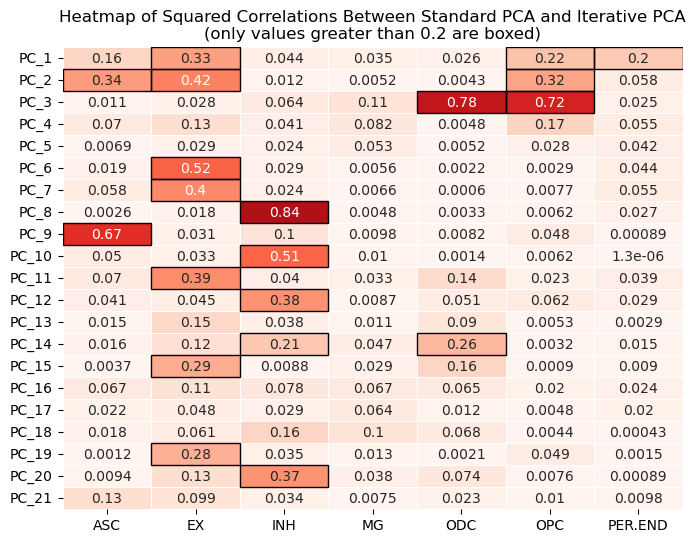

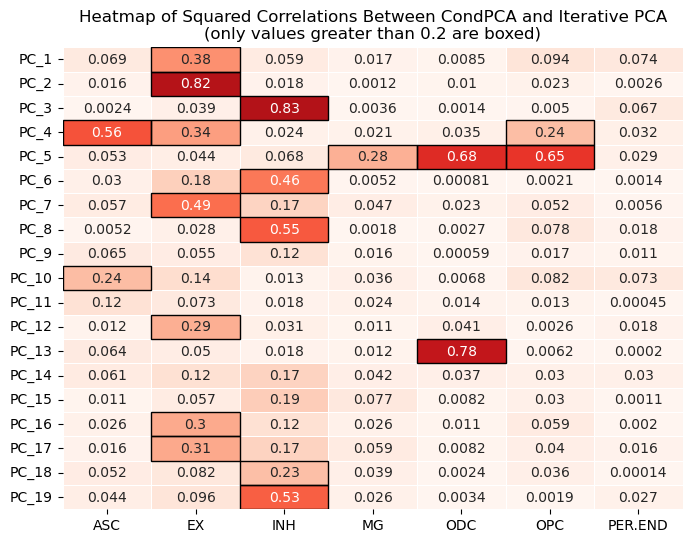

In [36]:
# test.SStandardPCA_IterPCA_squared_correlations
# #test.StandardPCA_IterPCA_squared_correlations
# global_ct_cutoff = 0.2
# PCA_type = "Standard PCA"
# #df = test.StandardPCA_IterPCA_squared_correlations.apply(pd.to_numeric, errors='coerce')
# # Create a heatmap using seaborn
# data = test.StandardPCA_IterPCA_squared_correlations

# # Create a mask for values greater than 0.20
# mask = data > global_ct_cutoff 

# plt.figure(figsize=(8, 6))
# sns.heatmap(data, annot=True, cmap='Reds', linewidths=.5, vmin=0, vmax=1, cbar=False)

# # Add boxes only around entries greater than 0.20
# for i in range(data.shape[0]):
#     for j in range(data.shape[1]):
#         if mask.iloc[i, j]:
#             rect = plt.Rectangle((j, i), 1, 1, linewidth=1, edgecolor='black', facecolor='none')
#             plt.gca().add_patch(rect)

# plt.title(f'Heatmap of Squared Correlations Between {PCA_type} and Iterative PCA\n(only values greater than {global_ct_cutoff} are boxed)')
# plt.show()

# make the above code into a function
def _plot_heatmap_global_ct_specific(data, global_ct_cutoff, PCA_type):
    # Create a mask for values greater than 0.20
    mask = data > global_ct_cutoff 

    plt.figure(figsize=(8, 6))
    sns.heatmap(data, annot=True, cmap='Reds', linewidths=.5, vmin=0, vmax=1, cbar=False)

    # Add boxes only around entries greater than 0.20
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if mask.iloc[i, j]:
                rect = plt.Rectangle((j, i), 1, 1, linewidth=1, edgecolor='black', facecolor='none')
                plt.gca().add_patch(rect)

    plt.title(f'Heatmap of Squared Correlations Between {PCA_type} and Iterative PCA\n(only values greater than {global_ct_cutoff} are boxed)')
    plt.show()

_plot_heatmap_global_ct_specific(test.StandardPCA_IterPCA_squared_correlations, 0.2, "Standard PCA")
_plot_heatmap_global_ct_specific(test.CondPCA_IterPCA_squared_correlations, 0.2, "CondPCA")

In [4]:
# # reading in from my method
# norm_a = test.count_matrix.X
# scale_a = test.standardized_count_data
# standardized_residual_batch_age_sex_A = np.load('/Users/shayecarver/condPCA/final_method/test_dfs/my_method_standardized_residual_STAND.npy')
# standardized_residual_batch_age_sex_celltype_A = np.load('/Users/shayecarver/condPCA/final_method/test_dfs/standardized_residual_COND.npy')
# ODC_stand_resid_batch_age_sex_A = np.array(pd.read_csv("/Users/shayecarver/condPCA/final_method/test_dfs/ODC_stand_resid_batch_age_sex.txt", sep='\t', header=0, index_col=0) )

# # reading in from seurat or base R
# norm_b = np.array(pd.read_csv("/Users/shayecarver/condPCA/final_method/test_dfs/norm_test_matrix.txt", sep='\t', header=0, index_col=0))
# scale_b = np.array(pd.read_csv("/Users/shayecarver/condPCA/final_method/test_dfs/scale_test_matrix.txt", sep='\t', header=0, index_col=0))
# seurat_standardized_residual_batch_age_sex_B = np.array(pd.read_csv("/Users/shayecarver/condPCA/final_method/test_dfs/SEURAT_scale_counts_regress_batch_age_sex.txt", sep='\t', header=0, index_col=0)) # residual computed in seurat
# standardized_residual_batch_age_sex_B = np.array(pd.read_csv("/Users/shayecarver/condPCA/final_method/test_dfs/base_R_standardized_residual_test_matrix.txt", sep='\t', header=0, index_col=0)) #residual computed in base R
# standardized_residual_batch_age_sex_celltype_B = np.array(pd.read_csv("/Users/shayecarver/condPCA/final_method/test_dfs/base_R_standardized_residual_test_matrix_w_CELLTYPE.txt", sep='\t', header=0, index_col=0)) #residual computed in base R
# ODC_stand_resid_batch_age_sex_B = np.array(pd.read_csv("/Users/shayecarver/condPCA/final_method/test_dfs/base_R_standardized_residual_iter_PCA_ODC_SCANPY_VARGENES_NOT_SEURAT.txt", sep='\t', header=0, index_col=0) )
# stand_PCA_B = np.array(pd.read_csv("/Users/shayecarver/condPCA/test_dfs/final_method/base_R_PCA_STAND.txt", sep='\t', header=0, index_col=0) )
# stand_eigenvalues = np.array(pd.read_csv("/Users/shayecarver/condPCA/final_method/test_dfs/base_R_PCA_STAND_eigenvalues.txt", sep='\t', header=0, index_col=0) )[0:50]
# cond_PCA_B = np.array(pd.read_csv("/Users/shayecarver/condPCA/final_method/test_dfs/base_R_PCA_COND.txt", sep='\t', header=0, index_col=0) )
# cond_eigenvalues = np.array(pd.read_csv("/Users/shayecarver/condPCA/final_method/test_dfs/base_R_PCA_COND_eigenvalues.txt", sep='\t', header=0, index_col=0) )[0:50]

# # function checking consistency between two matrices (taking inner product of matched index column of two matrices)
# def inner_prod_similarity(MatrixA, MatrixB): # compute inner product similarity between two matrices
#     similarity = np.sum(np.array(MatrixA) * MatrixB, axis=0) / (np.linalg.norm(MatrixA, axis=0) * np.linalg.norm(MatrixB, axis=0))
#     print(f'sum should be ~2000: {sum(abs(similarity) )}')
#     return similarity


# # printing the sum of the normalized innter product between two matrices (which should equal 2000 because there are 2000 genes, 2000 columns)
# inner_prod_similarity(norm_a,norm_b) 
# inner_prod_similarity(scale_a,scale_b)
# inner_prod_similarity(standardized_residual_batch_age_sex_A,seurat_standardized_residual_batch_age_sex_B)
# inner_prod_similarity(standardized_residual_batch_age_sex_A,standardized_residual_batch_age_sex_B)
# inner_prod_similarity(standardized_residual_batch_age_sex_celltype_A,standardized_residual_batch_age_sex_celltype_B)
# inner_prod_similarity(ODC_stand_resid_batch_age_sex_A,ODC_stand_resid_batch_age_sex_B)
# inner_prod_similarity(test.STANDARD_gene_loadings,stand_PCA_B) # should be 50 because comparting 50 vectors
# inner_prod_similarity(test.STANDARD_eigenvalues,stand_eigenvalues) # should be 1 because comparing to vectors
# inner_prod_similarity(test.COND_gene_loadings,cond_PCA_B) # should be 50 because comparting 50 vectors
# inner_prod_similarity(test.COND_eigenvalues,cond_eigenvalues) # should be 1 because comparing to vectors

FileNotFoundError: [Errno 2] No such file or directory: '/Users/shayecarver/condPCA/final_method/test_dfs/my_method_standardized_residual_STAND.npy'

,Column1
0,1


In [136]:
# instantiate class
test = condPCA(count_matrix_path="/Users/shayecarver/condPCA/final_method/test_matrix.txt", metadata_path="/Users/shayecarver/condPCA/final_method/test_metadata.txt", object_columns=['Batch', 'Sex','celltype'], save_image_outputs=False) # object_columns are columns that must be factors
test.Normalize()
test.Standardize()
test.CondPCA_fit()
test.StandardPCA_fit()
test.Iter_PCA_fit()

In [140]:
test.ITER_cell_embeddings['ASC']

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,PC_11,PC_12,PC_13,PC_14,PC_15,PC_16,PC_17,PC_18,PC_19,PC_20
ATTTACCAGTTTAGGA-18,-4.300272,-0.428760,-1.780357,-1.167064,-0.489646,-0.440957,-3.303616,1.984256,0.085696,-0.200236,-0.508424,0.621815,-1.125159,-1.388991,0.148711,-0.133543,2.208073,-1.531956,-1.473742,1.243949
AGTGACTAGCAGCCCT-13,-3.261901,-1.415951,1.597469,-0.243218,0.161364,-2.194491,0.766569,-0.268117,-0.061097,0.261288,-0.023729,1.433358,-0.942435,0.307743,-0.473366,1.574751,1.392048,0.790111,-0.430011,-0.098871
GGGACAACACGACTAT-1,-2.405542,-1.754481,0.258975,-0.634269,-0.937164,-1.569662,1.206221,0.485777,1.583452,-0.449200,-0.111230,1.729674,-0.325881,0.056126,-0.308454,-0.025615,-1.467872,0.345668,0.529667,0.420384
TTATTGCCAGGACTTT-5,-1.289533,4.861984,0.466467,-1.051763,2.486831,-1.042302,2.545094,1.618596,3.351776,2.487712,3.246058,1.464754,-1.004717,-1.601220,-0.387735,0.090023,-1.512685,-1.646790,-1.007512,0.871888
GCATGATAGGGAGATA-8,5.353141,-0.516729,-2.361029,-4.219701,-0.891767,-2.199218,-0.026757,1.479904,-0.795403,1.742622,-1.787930,1.179853,0.397820,-0.775183,2.595121,-3.750874,-0.570805,1.114259,1.374047,-3.202281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CAAGGGATCAGACCTA-7,5.817109,2.441118,6.162140,3.612909,0.395550,1.629669,-1.435855,0.400616,0.080176,0.248444,4.355696,-0.284983,0.220100,3.541543,-1.697997,-1.167737,0.356015,3.372816,-0.244645,1.143193
TAGACTGTCATGCATG-9,5.269309,-0.928903,0.104477,0.746728,-1.351026,-0.894522,-0.884517,-0.268599,0.303392,-0.042039,-1.622438,-0.942329,-1.770810,-1.687759,-1.743903,-0.772113,-0.016315,-0.092537,-1.203965,-1.628971
AGCCACGTCCACAAGT-10,-1.243910,-1.070684,1.975469,1.854443,-0.581000,-0.955389,0.787313,-0.917349,-0.246262,0.048529,-0.549536,0.463297,-0.946879,0.440766,0.155793,0.049929,-1.450055,-0.735740,-0.187971,-0.097830
ACGGGTCAGCTTCATG-9,-1.486682,-1.812212,0.311320,1.502167,0.513324,0.598871,-0.650322,-0.629257,-0.973166,0.084431,0.061767,0.139208,-0.568188,-0.827760,-1.233978,0.493659,-0.425303,-0.325823,-0.390718,-1.142467
